# RNN
- https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html
- 이름을 기준으로 18개의 국가 카테고리 분류
- 문자 기반의 RNN모델로  이름 생성

## 1. data load 및 전처리

In [1]:
from io import open
import glob
import os
import unicodedata
import string


In [20]:
# 유니코드 문자열을 ASCII로 변환
# https://stackoverflow.com/a/518232/2809427

all_letters = string.ascii_letters + " .,;'"
print('all_letters:', all_letters)
n_letters = len(all_letters)   # 모든 letters 개수: 56
print('n_letters', n_letters)


def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(all_letters, s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'MN'
    and c in all_letters
    )

print(unicodeToAscii(all_letters, 'Ślusàrski'))


all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
n_letters 57
Slusarski


In [21]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위 분리
def readLines(filename):
    lines = open(filename, encoding ='utf-8').read().strip().split('\n')
    return [unicodeToAscii(all_letters, line) for line in lines]

datapath = '../assets/data/nlp/7_RNN_names/*.txt'

for filename in findFiles(datapath):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [54]:
print('caregory', category_lines.keys())
print('caregory len', n_categories)


caregory dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])
caregory len 18


In [23]:
category_lines['Italian'][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

In [24]:
# Tensor 변환
import torch


def letterToIndex(letter):
    """all_letters로 문자의 주소 찾기
    예: "a" = 0
    """
    return all_letters.find(letter)

def letterToTensor(letter):
    """ 
    원핫인코딩
    검증을 위해서 1개의 문자를 1 * n_letters type의 tensor 변환"""
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    """ 한 줄을 [line_length * 1* n-letters] 또는 one hot 문자 벡터의 Array로 변경
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1

    return tensor

print(letterToTensor('J'))
print(letterToTensor('J').size())
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 57])
torch.Size([5, 1, 57])


## 2. Model

![RNN_model](../assets/img/nlp/7_RNN_code_model.png)

In [28]:
import torch.nn as nn
from torchsummary import summary


In [48]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden ( self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [49]:
# 첫 단계: 현제 문자 tensor + 이전 은닉 상태(0으로 초기화) 전달
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
print('input size', input.size())
print('hidden_size', hidden.size())

output, next_hidden = rnn(input, hidden)
print('output_size', output.size())
print('next_hidden size', next_hidden.size())

input size torch.Size([1, 57])
hidden_size torch.Size([1, 128])
output_size torch.Size([1, 18])
next_hidden size torch.Size([1, 128])


In [50]:
# input을 문자보다 line(word) 단위로 넣어서 효율적으로 연산
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)

## 3.utiles 함수 

In [51]:
def categoryFromOutput(output):
    """ 네트워크 출력을 가장 확률이 노은 카테고리 이름과 번호를 반환"""
    top_n, top_i = output.topk(1)    # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 10)


In [52]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category,line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/line =', line)

category =  Russian /line = Molvo
category =  Vietnamese /line = Trieu
category =  French /line = Moreau
category =  Portuguese /line = Freitas
category =  English /line = Jacques
category =  German /line = Brose
category =  Scottish /line = Murray
category =  Chinese /line = Qiu
category =  English /line = Barker
category =  Dutch /line = Niftrik


## 5. 학습

In [56]:
criterion = nn.NLLLoss()

learning_rate = 0.005

def train (category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()


    # 매개변수의 경사도에 학습률 곱해서 그 매개변수값데 더하기-> 가중치 업데이트
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)


    return output, loss.item()

In [58]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds'%(m,s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # 'iter' 숫자, 손실, 이름 추축 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s'%(iter, iter/n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스ㅡ에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0




5000 5% (0m 7s) 2.4314 Aberquero / Portuguese ✗ (Spanish)
10000 10% (0m 15s) 2.0123 Koguchi / Italian ✗ (Japanese)
15000 15% (0m 23s) 3.0764 Graham / Arabic ✗ (Scottish)
20000 20% (0m 31s) 2.9047 Forestier / German ✗ (French)
25000 25% (0m 39s) 1.0906 Ventura / Spanish ✓
30000 30% (0m 46s) 0.8971 Khu / Chinese ✓
35000 35% (0m 54s) 2.2329 Mcdonald / Irish ✗ (Scottish)
40000 40% (1m 2s) 2.7498 Schwartz / Scottish ✗ (Czech)
45000 45% (1m 10s) 0.1111 Belchenkov / Russian ✓
50000 50% (1m 18s) 4.4232 Carideo / Portuguese ✗ (Italian)
55000 55% (1m 26s) 2.5903 Sai / Chinese ✗ (Vietnamese)
60000 60% (1m 34s) 0.2626 Panayiotopoulos / Greek ✓
65000 65% (1m 42s) 1.1567 Rosario / Portuguese ✓
70000 70% (1m 49s) 2.9112 Ramos / Greek ✗ (Spanish)
75000 75% (1m 57s) 0.0635 Mancini / Italian ✓
80000 80% (2m 5s) 0.0816 Than / Vietnamese ✓
85000 85% (2m 13s) 3.7823 Park  / Russian ✗ (Korean)
90000 90% (2m 20s) 0.1770 Otsuka / Japanese ✓
95000 95% (2m 28s) 0.7178 Zawisza / Polish ✓
100000 100% (2m 36s) 1.3

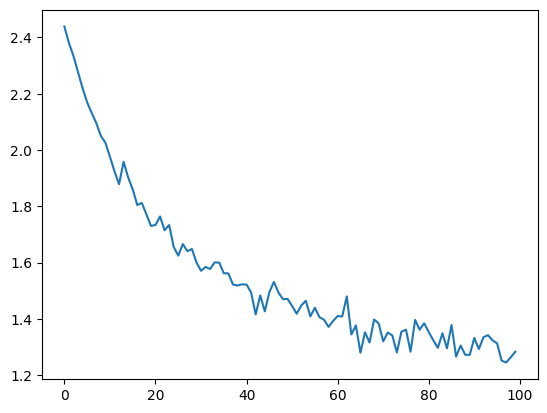

In [59]:
# 결과 도식화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


## 6. 결과 평가

C:\Users\shiney\AppData\Local\Temp\ipykernel_285464\623802815.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\shiney\AppData\Local\Temp\ipykernel_285464\623802815.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


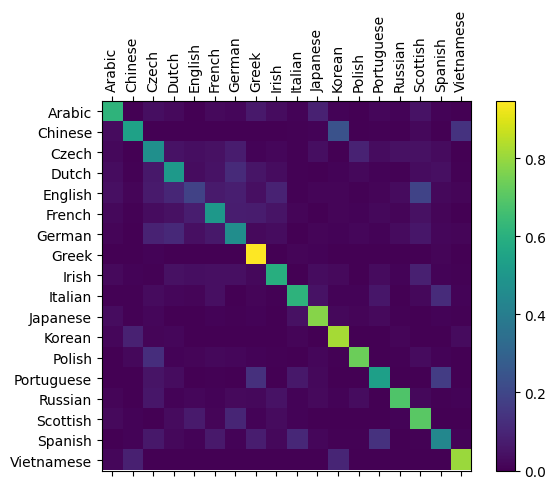

In [60]:
# confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden =rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시 중 어떤 것이 정확히 에측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor =randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i= all_categories.index(category)
    confusion[category_i][guess_i] += 1


# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

- 한국어는 중국어로, 베트남어로 잘못 인식하는 경우 많음.
- 그리스어는 분류 잘하고, 영어는 성능이 제일 떨어짐(다른 언어들과의 중첩 때문으로 추정)